<a href="https://colab.research.google.com/github/WayneGretzky1/CSCI-4521-Applied-Machine-Learning/blob/main/4_3_logistic_regression_on_digits%2C_sgd%2C_roc_curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are going to wrap up our in-depth study of binary classification by looking at the binary classification of image data into the digit 9 vs the digits 0-8.

Our goal will be to set up logistic regression using PyTorch. Here we will make use of common PyTorch features such as modules and the dataset loader.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

## Loading MNIST Data

As a first step, download all the MNIST digits. This should take 1-2 minutes to download, so start now while you read the rest of the document.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(data_id=554) # https://www.openml.org/d/554

This data is formatted with the data separate from the labels. The data itself has some extra information. We can get the raw values by calling `mnist.data.values`. Here we look at 1 of the entries.

In [3]:
mnist.data.values[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  51, 159, 253,
       159,  50,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  48, 238,
       252, 252, 252, 237,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

This is 784 values. If we reshape them into a 28x28 grid, they form an image. We'll use the following helper function to plot the images.

In [4]:
def plot_digits(data,img_size=28, rows=10):
  fig, ax = plt.subplots(rows, 10, figsize=(8, 8),
                          subplot_kw=dict(xticks=[], yticks=[]))
  fig.subplots_adjust(hspace=0.05, wspace=0.05)
  for i, axi in enumerate(ax.flat):
      if i < data.shape[0]:
        im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
      im.set_clim(0, 16)

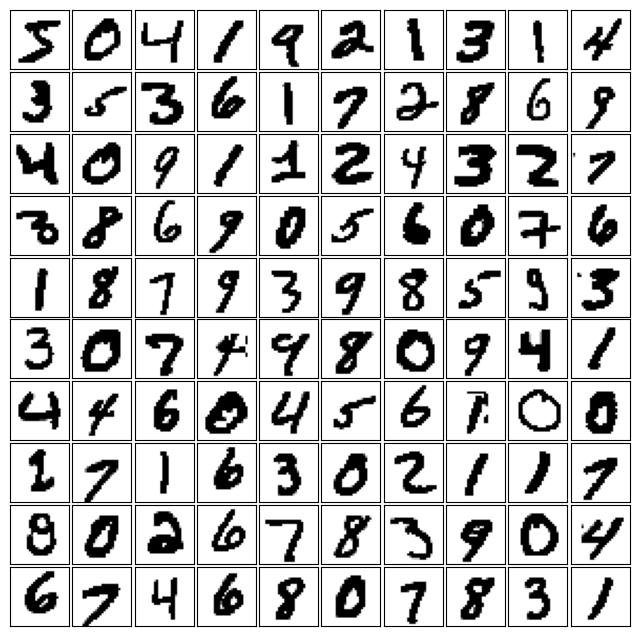

In [5]:
plot_digits(mnist.data.values)

We'll also create a variant of `plot_digits` which takes as input a model and data, and labels the images with the actual and predicted classes.

In [6]:
def plot_digits_with_predictions(model, data, labels, img_size=28, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=2.0, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).item()
          drawColor = 'black'
          if (pred_label>0) != (labels[i]>0.5):
            drawColor = 'red'
          axi.set_title("label:{}\npred:{:1.2f}".format(labels[i],pred_label), color=drawColor)
        im.set_clim(0, 16)

There are a lot of images here. We'll use the first 60,000 for testing and the remaining 10,000 for training.

In [7]:
mnist_training_data = mnist.data.values[0:60000,:] #Keep the first 60000 samples for training
mnist_training_labels = mnist.target.values[0:60000]
mnist_testing_data = mnist.data.values[60000:,:] #Test on the rest
mnist_testing_labels = mnist.target.values[60000:]

Before moving on, make sure you understand what the shape of all these vectors is and why the vectors have these shapes.

In [8]:
mnist_testing_data.shape

(10000, 784)

Our binary classification task will be to look at a digit and classify if it's a `9` or some other digit `0`-`8`.

We need to make a label for testing and training data that is `1` when they are `9` and `0` otherwise.

In [9]:
mnist_training_label_is_nine = 1.0*(mnist_training_labels=='9')
mnist_testing_label_is_nine = 1.0*(mnist_testing_labels=='9')

We actually have a small issue. The features are stored in a 2D matrix, but the labels ended up in a 1D vector:

In [10]:
print(mnist_training_data.shape)
print(mnist_training_label_is_nine.shape)

(60000, 784)
(60000,)


This will cause a headache later on. To fix this, we can call `np.expand_dims(vector_data, 1)`, which will upgrade our 1D vector data into a 2D matrix.

In [11]:
mnist_training_label_is_nine = np.expand_dims(1.0*(mnist_training_labels=='9'),1)
mnist_testing_label_is_nine = np.expand_dims(1.0*(mnist_testing_labels=='9'),1)
print(mnist_training_data.shape)
print(mnist_training_label_is_nine.shape)

(60000, 784)
(60000, 1)


### Data to PyTorch Dataset

Rather than always working with raw collections of arrays or tensors, PyTorch provides a `Dataset` class that allows you to keep the data features and labels bundled together. The `Dataset` requires you to implement the `__init__` method where you create the data, a `__len__` method which reports the number of data entries, and a `__getitem__` method which returns whatever data entry is at the given index.

Here, we inheret from the `Dataset` class to make a new class that accepts two numpy arrays of floats as input (one for features and one for labels) and stores the outcomes as PyTorch tensors.

In [12]:
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).float()

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index]
      y = self.output_tensor[index]

      return X, y

We can now load our training and testing features/labels into a `Dataset`:

In [13]:
training_dataset = NumpyDataset(mnist_training_data,mnist_training_label_is_nine)
testing_dataset = NumpyDataset(mnist_testing_data,mnist_testing_label_is_nine)

You can see that pulling up a single entry of our dataset will now bundle together the feature tensor and the label.

In [14]:
training_dataset[0] #a tuple of tensors

(tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,  

## Training Helper Functions

To actually do our training, we'll make use of several generic "infrastructure" functions for training and testing models (represented as PyTorch modules) in PyTorch.
- `train` takes as input a model, a data generator, a loss function, and an optimizer, and will update the model to reduce loss on the examples in the data generator
- `test` takes in a model, a data generator, and a loss function to return the average loss
- `logResult` stores the test and training loss in the vectors passed in and prints out the loss to the console
- `graphLoss` shows the trend in the loss over training epochs for both the testing and training data
- `trainAndGraph` uses the above function to train a model, compute the testing and training losses, and graph the results

### Training and Model Optimizers

We also need to decide on an optimization strategy to update our parameters based on the weight. Before, we implemented gradient descent with the following update strategy:
 `params -= learning_rate * params.grad`

Now that we are looping over batches, the gradient on our parameters is no longer based on the loss over the entire dataset, but only on the loss from whatever samples happen to be in our current batch. The results look like so:
```
for each batch in the current epoch:
  predictions_current_batch = model(inputs_current_batch)
  params.zero_out_gradients()
  loss = error(predictions_current_batch, inputs_current_batch)
  loss.backward() #update gradients
  params -= learning_rate * params.grad #SGD Optimization
```
Were we update the parameters several times each epoch.

This approach of updating the parameters several times within an epoch using the gradient from the current batch is called **Stochastic Gradient Descent** or Minibatch Stochastic Gradient Descent, and is normally abbreviated SGD.

Torch has a built-in implementation of SGD, which we can use by passing in our model's parameters and a learning rate.

```optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)```

Torch has many optimizers built-in. For this activity, we'll try Adam, which is as simple as calling:

```optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)```

Adam makes several improvements to SGD, such as using a different learning rate for each parameter and averaging gradients over several batches to help avoid local minima.

We can now call `optimizer.step()` to have it update the parameters via SGD.

Below is a function `train()` that takes a network model, data generator, loss function, and optimizer as inputs and trains the model parameters. Here, we have `train()` return the average loss over the epoch so that we can graph it later.

In [15]:
def train(model,  data_generator, loss_function, optimizer):
  model.train() #updates any model layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    #print(input_data)
    #print(input_data.shape)
    prediction = model(input_data)                   # Forward pass: compute the output class given a image

    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss/num_batches

As a counterpart to our training function, we can also create a function `test()` which tests our model on our loss function. Like `train()`, `test()` returns the average loss so we can monitor it.

Unlike the training function, when testing the network we don't want to update any of the gradients (which is why we make a `with torch.no_grad():` block). Additionally, we'll see in future lectures that some network layers behave differently in testing and training (a common example is to add some random noise during training to make your model more robust, but not during testing). Calling `network.train()` or `network.test()` allows these layers to know what mode they should be in. Lastly, we don't call the optimizer during testing/evaluation of the network.

In [16]:
def test(model, test_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss


### Logging and graphing

In order to analyze our results more effectively, we will need a few helper functions. The first, `logResults()`, prints out the loss every few epochs and saves the testing and training loss to be graphed later on.

In [17]:
def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

And lastly, `graphLoss()` graphs the testing and training loss versus the number of epochs.

In [18]:
def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

Finally, we pull everything together in the function `trainAndGraph()`. This function creates arrays to store the loss values, calls the `train()` and `test()` functions on the network model, and runs the final trained model on all the data for analysis. We also use the helper functions above to graph the results of the model and plot the loss over time.

In [19]:
def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []

  for epoch in range(num_epochs):
    avg_loss = train(model, training_generator, loss_function, optimizer)
    test_loss = test(model, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

### Measuring Accuracy

As this is a classification problem, we'd like to be able to compute the accuracy of our `model`. The below code assumes that if the prediction is positive, we are predicting class `1`; otherwise, the prediction should be interpreted as class `0`.

In [20]:
def computeLabelAccuracy(model, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = model(data)
      correct += (output>0).eq(target>0).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

## Predictive Model

We will extend Torch's built-in `Module` class. This class does a lot of bookkeeping for us, such as keeping track of all the weights/parameters our model is using.

A `Module` class needs to have an `__init__()` function to set up the model and a `forward()` function. The `forward()` function needs to take a tensor as an input and return a tensor as an output, representing the model's prediction.

We will use one of the simplest possible models, just a matrix multiplication. That is, our prediction will be the input tensor multiplied by a matrix of weights. After we flatten out the 28x28 images into a 1D vector, our input is $n$ 784x1 images (a 784x$n$ matrix), and our output is $n$ numbers, one for each image representing which class we predict it to be in (a 1x$n$ matrix). So, we need our prediction matrix of weights to be a 1x784 matrix.

Note: This approach allows us to predict over multiple input features at once! The process of processing a group of predictions through your model simultaneously is called **batching**, where we have $n$ items in our batch. Given the great support for parallel computing on modern hardware, batching allows us to greatly speed up computation.

In [21]:
class LinearClassifier(nn.Module):
    def __init__(self, img_w, img_h, numClasses):  #For binary predictions numClasses = 1 is fine
        super().__init__()
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, numClasses)

    def forward(self, x):
        x = x.view(-1,self.flatSize)  #Pytorch will replace -1 with the batch size

        x = self.linear1(x)
        return x

Before we can train a model, we'll need to specify a loss function. This function measures how close the predictions are to the actual labels. In this case, we'll use the mean squared error.

Note that we need to compute the average the error across all the samples in the batch.

In [22]:
def MSE(output, target): #L2 Loss - same as nn.MSELoss()
   loss = torch.mean((output - target)**2)
   return loss

Loaded Data
Epoch [1/30], Train Loss: 748.4264, Test Loss: 458.8245
Epoch [6/30], Train Loss: 176.6508, Test Loss: 163.9200
Epoch [11/30], Train Loss: 117.2497, Test Loss: 111.3804
Epoch [16/30], Train Loss: 89.9964, Test Loss: 86.1087
Epoch [21/30], Train Loss: 73.7346, Test Loss: 70.7965
Epoch [26/30], Train Loss: 62.6766, Test Loss: 60.2895


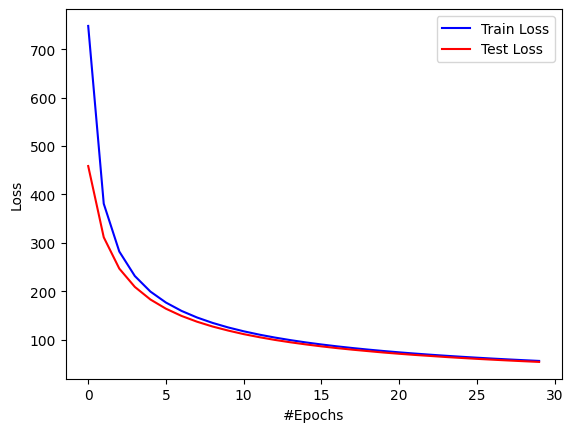

In [23]:
#Training parameters
num_epochs = 30
print_interval = 5
learning_rate = 0.00000001
batch_size = 100

#MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
predModel = LinearClassifier(image_w, image_h, 1)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) #or torch.optim.Adam
loss_function = MSE #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

### Model Evaluation

We can check out the accuracy:

In [24]:
computeLabelAccuracy(model, training_generator, "Test Set")
computeLabelAccuracy(model, testing_generator, "Train Set")


Test Set: Accuracy: 29424/60000 (49.0%)

Train Set: Accuracy: 4946/10000 (49.5%)


Your results are probably not much better than random, maybe worse than random!

We can also look at which results were right and wrong visually, but I don't expect to see any clear trends given the bad predictions.

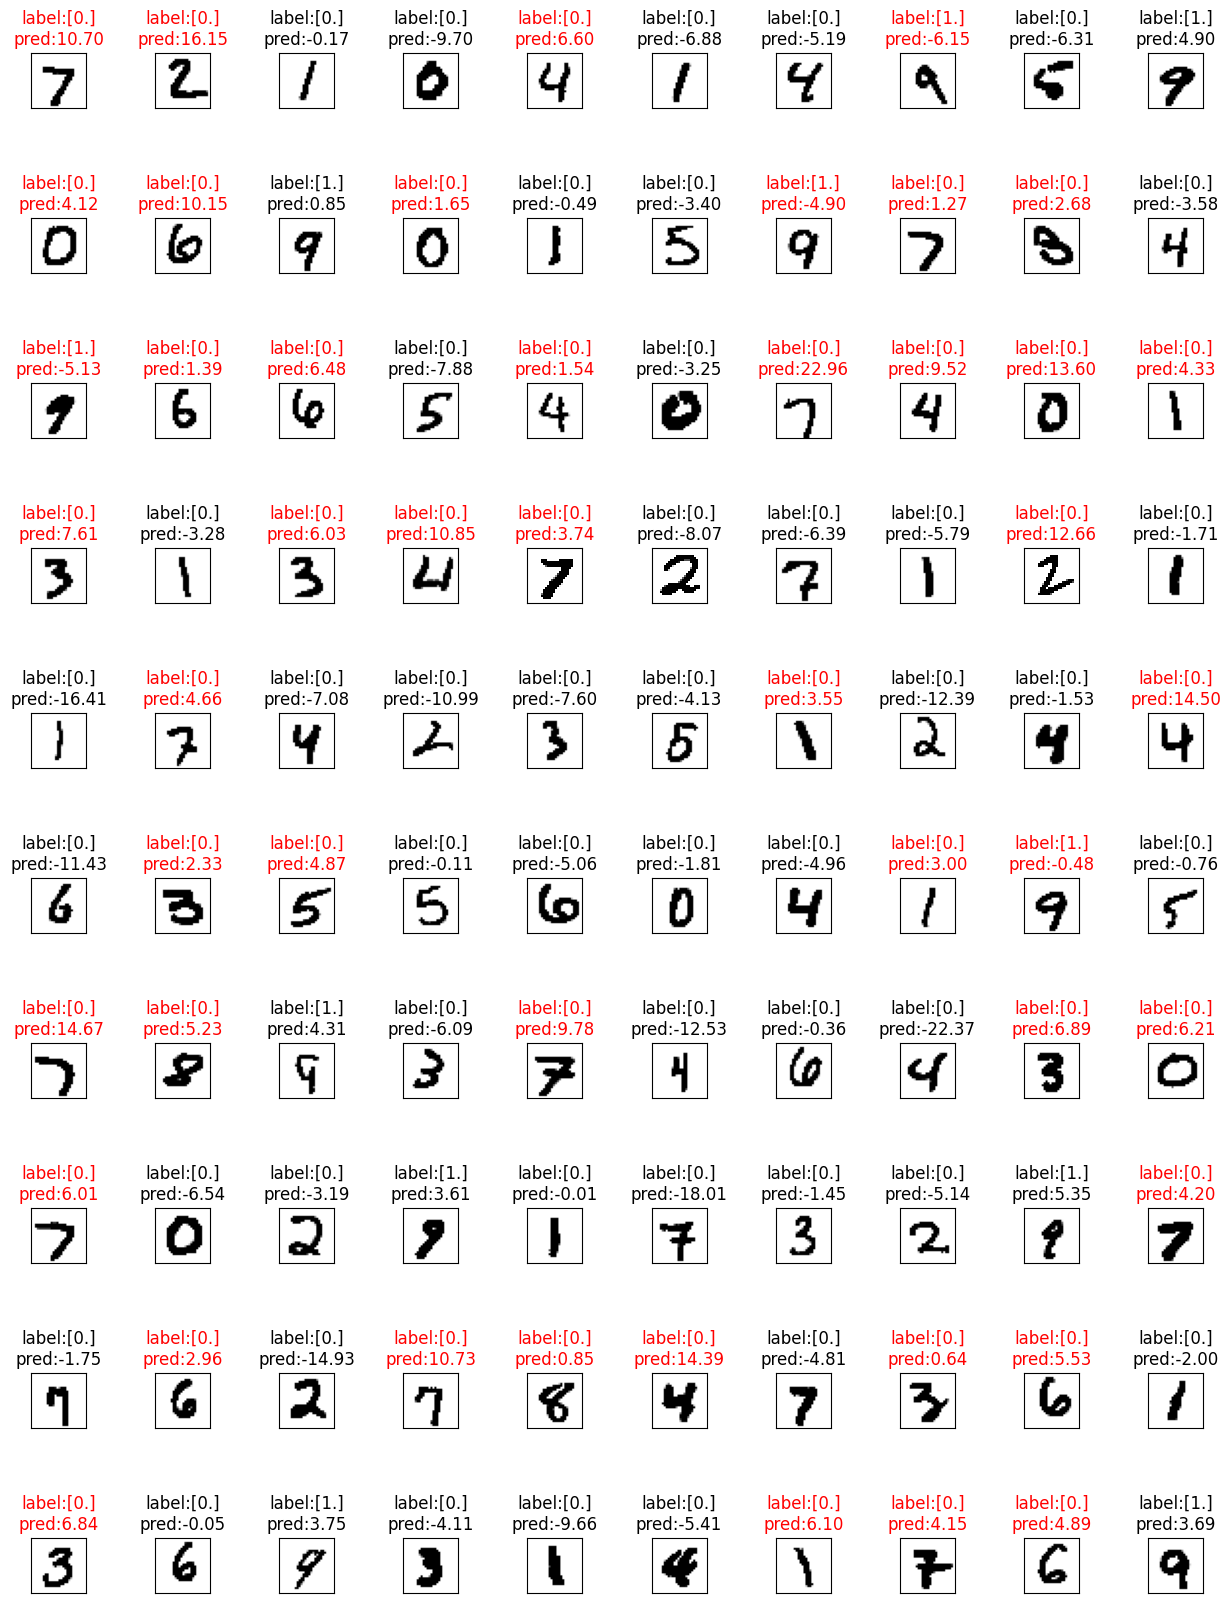

In [25]:
plot_digits_with_predictions(model,mnist_testing_data,mnist_testing_label_is_nine)

AUC: 0.5168089573992007
Precision [0.90529133 0.10674703]
Recall [0.4890446  0.54410307]
F1 [0.63503755 0.17847854]
Count [8991 1009]


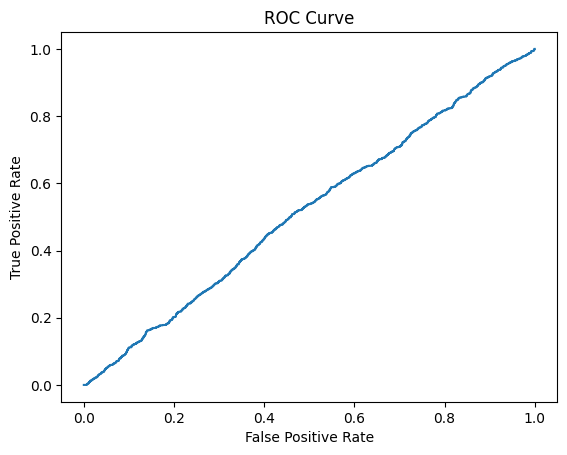

In [26]:
preds = model(torch.tensor(mnist_testing_data).float()).detach().numpy()
fpr, tpr, thresholds = metrics.roc_curve(mnist_testing_label_is_nine,preds)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
print("AUC:",metrics.auc(fpr, tpr))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
p,r,f,count = metrics.precision_recall_fscore_support(mnist_testing_label_is_nine,preds>0)
print("Precision",p)
print("Recall",r)
print("F1",f)
print("Count",count)

## Logistic Regression

What went wrong? Our loss went down, but the predictions are not very good.

The issue can be fixed by updating our loss. Rather than taking the raw model output (which can quickly go outside the range 0-1), we can calculate the loss with respect to the sigmoid of the model output.

Sigmoid is the function $f(x) = \frac{1}{1+e^{-x}}$, which will natural clamp the model resutls between 0 and 1. It means that no matter how large or small the input $x$ is, the output of the sigmoid function will always be between 0 and 1, which will help make the loss more meaningful.

In [27]:
def SigmoidLoss(output, target): #L2 Loss - same as nn.MSELoss()
   loss = torch.mean((torch.sigmoid(output) - target)**2)
   return loss

1. Reproduce the training we did above, but this time use the Sigmoid Loss (i.e., use logistic regression). What are your testing and training accuracies? Did they improve from before?

2. Visualize your predictions. Do you notice any trends?

3. Compute the precision, recall, and F1 score for your logistic regression classifier. Do you have good values for both classes?

4. What is special about this problem that is making it hard to get a good F1 score for both classes?

5. Fix the problem (somehow) that you identified in Question 4. What is your updated accuracy, F1 score, and AUC? (Try to get an F1 score of at least 0.5 in both classes.)

Loaded Data
Epoch [1/30], Train Loss: 0.4991, Test Loss: 0.5020
Epoch [6/30], Train Loss: 0.4939, Test Loss: 0.4967
Epoch [11/30], Train Loss: 0.4887, Test Loss: 0.4914
Epoch [16/30], Train Loss: 0.4834, Test Loss: 0.4862
Epoch [21/30], Train Loss: 0.4781, Test Loss: 0.4811
Epoch [26/30], Train Loss: 0.4728, Test Loss: 0.4760


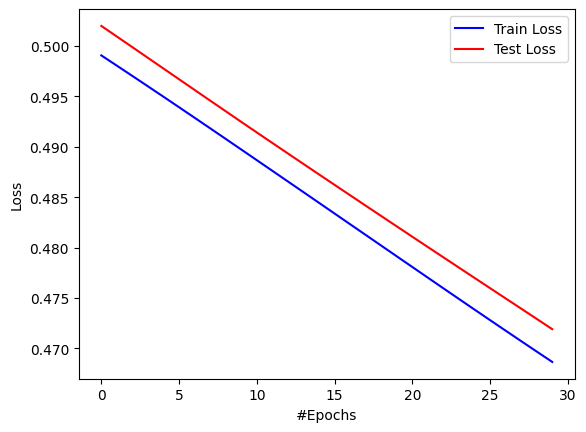

In [29]:
#Training parameters
num_epochs = 30
print_interval = 5
learning_rate = 0.00000001
batch_size = 100

#MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
predModel = LinearClassifier(image_w, image_h, 1)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) #or torch.optim.Adam
loss_function = SigmoidLoss #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

In [30]:
computeLabelAccuracy(model, training_generator, "Test Set")
computeLabelAccuracy(model, testing_generator, "Train Set")


Test Set: Accuracy: 31239/60000 (52.1%)

Train Set: Accuracy: 5176/10000 (51.8%)


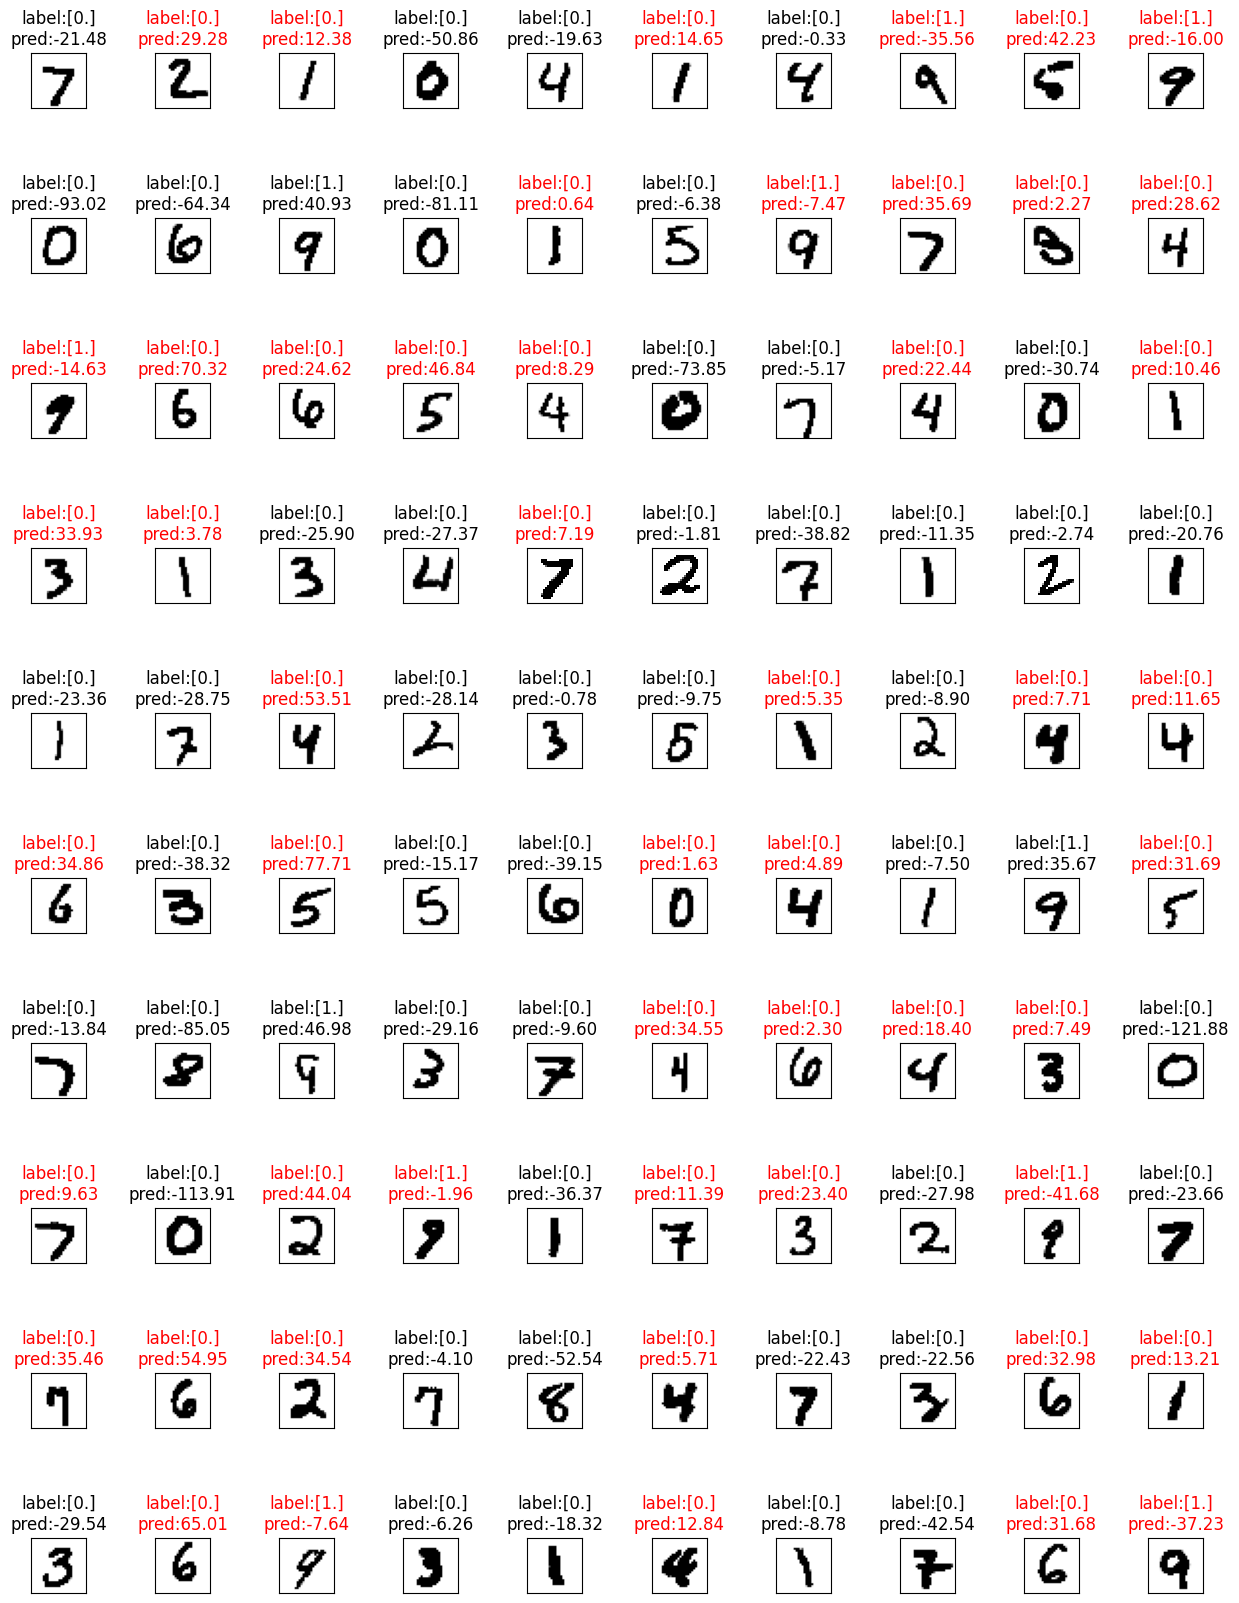

In [31]:
plot_digits_with_predictions(model,mnist_testing_data,mnist_testing_label_is_nine)

AUC: 0.45049818015350446
Precision [0.88306674 0.08178031]
Recall [0.53420087 0.36967294]
F1 [0.66569647 0.13393178]
Count [8991 1009]


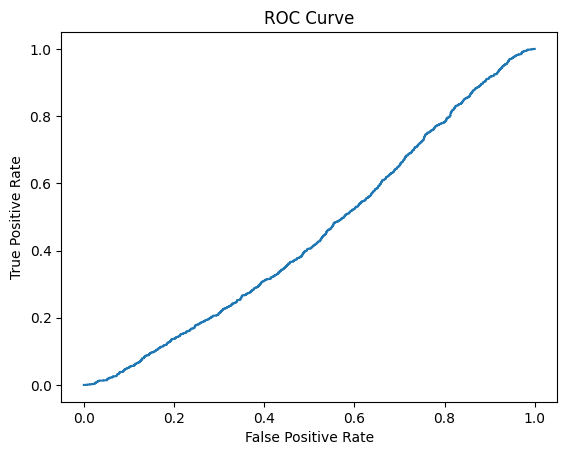

In [32]:
preds = model(torch.tensor(mnist_testing_data).float()).detach().numpy()
fpr, tpr, thresholds = metrics.roc_curve(mnist_testing_label_is_nine,preds)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
print("AUC:",metrics.auc(fpr, tpr))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
p,r,f,count = metrics.precision_recall_fscore_support(mnist_testing_label_is_nine,preds>0)
print("Precision",p)
print("Recall",r)
print("F1",f)
print("Count",count)